## LDA topic modeling with sklearn

In [1]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
import string
import csv

import warnings
warnings.filterwarnings("ignore")

In [2]:
# stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

def read_in_csv(csv_file):
    with open(csv_file, 'r', encoding='utf-8') as fp:
        reader = csv.reader(fp, delimiter=',', quotechar='"')
        data_read = [row for row in reader]
    return data_read

def get_stopwords(path):
    stopwords = read_in_csv(path)
    stopwords = [word[0] for word in stopwords]
    stemmed_stopwords = [stemmer.stem(word) for word in stopwords]
    stopwords = stopwords + stemmed_stopwords
    return stopwords

stopwords = get_stopwords('stopwords.csv')

In [3]:
def tokenize_and_stem(sentence):
    tokens = nltk.word_tokenize(sentence)
    filtered_token = [t for t in tokens if t not in string.punctuation]
    stems = [stemmer.stem(t) for t in filtered_token]
    return stems

In [4]:
bbc_dataset = '../Chapter04/bbc-text.csv'

In [5]:
def create_count_vectorizer(documents):
    count_vectorizer = CountVectorizer(stop_words=stopwords, tokenizer=tokenize_and_stem)
    data = count_vectorizer.fit_transform(documents)
    return count_vectorizer, data

In [6]:
def clean_data(df):
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    df['text'] = \
    df['text'].apply(lambda x: re.sub(r'\d', '', x))
    return df

In [7]:
def create_and_fit_lda(data, num_topics):
    lda = LDA(n_components=num_topics, n_jobs=-1)
    lda.fit(data)
    return lda

In [8]:
def get_most_common_words_for_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    word_dict = {}
    for topic_index, topic in enumerate(model.components_):
        this_topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        word_dict[topic_index] = this_topic_words
    return word_dict

In [9]:
def print_topic_words(word_dict):
    for key in word_dict.keys():
        print(f'topic {key}')
        print("\t", word_dict[key])

In [10]:
df = pd.read_csv(bbc_dataset)
df = clean_data(df)
documents = df['text']

In [11]:
num_topic = 5

In [12]:
vectorizer, data = create_count_vectorizer(documents)
lda = create_and_fit_lda(data, num_topic)

In [13]:
topic_words = get_most_common_words_for_topics(lda, vectorizer, 10)
print_topic_words(topic_words)

topic 0
	 ['film', 'year', 'best', 'music', 'award', 'm', 'show', 'star', 'includ', 'new']
topic 1
	 ['m', 'bid', 'compani', 'mail', 'execut', 'polic', 'firm', 'court', 'case', 'report']
topic 2
	 ['year', 'peopl', 'use', 'compani', 'firm', 'bn', 'market', 'new', 'servic', 'month']
topic 3
	 ['year', 'say', 'labour', 'elect', 'govern', 'parti', 'time', 'm', 'minist', 'peopl']
topic 4
	 ['game', 'player', 'play', 'time', 'first', 'technolog', 'o', 'half', 'use', 'video']


In [14]:
import pickle

In [15]:
model_path = "lda_sklearn.pkl"
vectorizer_path = "vectorizer.pkl"

In [16]:
new_example = """Manchester United players slumped
to the turf at full-time in Germany on Tuesday in
acknowledgement of what their latest pedestrian firsthalf display had cost them. The 3-2 loss at RB Leipzig
means United will not be one of the 16 teams in the draw
for the knockout stages of the Champions League. And
this is not the only price for failure. The damage will
be felt in the accounts, in the dealings they have with
current and potentially future players and in the faith
the fans have placed in manager Ole Gunnar Solskjaer.
With Paul Pogba's agent angling for a move for his
client and ex-United defender Phil Neville speaking of a
"witchhunt" against his former team-mate Solskjaer, BBC
Sport looks at the ramifications and reaction to a big
loss for United."""

In [17]:
def save_model(lda, lda_path, vect, vect_path):
    pickle.dump(lda, open(lda_path, 'wb'))
    pickle.dump(vect, open(vect_path, 'wb'))

In [18]:
def test_new_example(lda, vect, example):
    vectorized = vect.transform([example])
    topic = lda.transform(vectorized)
    print(topic)
    return topic

In [19]:
test_new_example(lda, vectorizer, new_example)

[[0.00349914 0.24799737 0.00356792 0.46620888 0.27872669]]


array([[0.00349914, 0.24799737, 0.00356792, 0.46620888, 0.27872669]])

## LDA topic modeling with gensim

In [20]:
import re
import pandas as pd
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from pprint import pprint


In [21]:
bbc_dataset = '../Chapter04/bbc-text.csv'
stopwords_file_path = "stopwords.csv"

In [22]:
# stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

def read_in_csv(csv_file):
    with open(csv_file, 'r', encoding='utf-8') as fp:
        reader = csv.reader(fp, delimiter=',', quotechar='"')
        data_read = [row for row in reader]
    return data_read

def get_stopwords(path):
    stopwords = read_in_csv(path)
    stopwords = [word[0] for word in stopwords]
    stemmed_stopwords = [stemmer.stem(word) for word in stopwords]
    stopwords = stopwords + stemmed_stopwords
    return stopwords

stopwords = get_stopwords(stopwords_file_path)

In [23]:
def clean_data(df):
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'\d', '', x))
    return df

In [24]:
def preprocess(df):
    df = clean_data(df)
    df['text'] = df['text'].apply(lambda x: simple_preprocess(x, deacc=True))
    df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stopwords])
    return df

In [25]:
def create_lda_model(id_dict, corpus, num_topics):
    lda_model = LdaModel(corpus=corpus, id2word=id_dict, num_topics=num_topics,
                        random_state=100, chunksize=100, passes=10)
    return lda_model

In [26]:
df = pd.read_csv(bbc_dataset)
df = preprocess(df)

In [27]:
texts = df['text'].values
id_dict = corpora.Dictionary(texts)
corpus = [id_dict.doc2bow(text) for text in texts]

In [28]:
number_topics = 5
lda_model = create_lda_model(id_dict, corpus, number_topics)

In [29]:
pprint(lda_model.print_topics())

[(0,
  '0.010*"net" + 0.008*"software" + 0.007*"users" + 0.007*"information" + '
  '0.007*"people" + 0.006*"attacks" + 0.006*"computer" + 0.006*"data" + '
  '0.006*"use" + 0.005*"firms"'),
 (1,
  '0.012*"people" + 0.006*"blair" + 0.005*"labour" + 0.005*"new" + '
  '0.005*"mobile" + 0.005*"party" + 0.004*"get" + 0.004*"government" + '
  '0.004*"uk" + 0.004*"election"'),
 (2,
  '0.012*"film" + 0.009*"best" + 0.006*"music" + 0.006*"year" + 0.005*"show" + '
  '0.005*"new" + 0.004*"uk" + 0.004*"awards" + 0.004*"films" + 0.004*"last"'),
 (3,
  '0.008*"game" + 0.006*"england" + 0.006*"first" + 0.006*"time" + '
  '0.006*"year" + 0.005*"players" + 0.005*"win" + 0.005*"world" + 0.005*"back" '
  '+ 0.005*"last"'),
 (4,
  '0.010*"bn" + 0.010*"year" + 0.007*"sales" + 0.005*"last" + '
  '0.004*"government" + 0.004*"new" + 0.004*"market" + 0.004*"growth" + '
  '0.004*"spending" + 0.004*"economic"')]


In [30]:
new_example = """Manchester United players slumped to the
turf
at full-time in Germany on Tuesday in acknowledgement of
what their
latest pedestrian first-half display had cost them. The
3-2 loss at
RB Leipzig means United will not be one of the 16 teams
in the draw
for the knockout stages of the Champions League. And this
is not the
only price for failure. The damage will be felt in the
accounts, in
the dealings they have with current and potentially
future players
and in the faith the fans have placed in manager Ole
Gunnar Solskjaer.
With Paul Pogba's agent angling for a move for his client
and ex-United
defender Phil Neville speaking of a "witchhunt" against
his former team-mate
Solskjaer, BBC Sport looks at the ramifications and
reaction to a big loss for United."""

In [31]:
def save_model(lda, lda_path, id_dict, dict_path):
    lda.save(lda_path)
    id_dict.save(dict_path)

In [32]:
def load_model(lda_path, dict_path):
    lda = LdaModel.load(lda_path)
    id_dict = corpora.Dictionary.load(dict_path)
    return (lda, id_dict)

In [33]:
def test_new_example(lda, id_dict, input_string):
    input_list = clean_text(input_string)
    bow = id_dict.doc2bow(input_list)
    topics = lda[bow]
    print(topics)
    return topics

In [34]:
def clean_text(input_string):
    input_string = re.sub(r'[^\w\s]', ' ', input_string)
    input_string = re.sub(r'\d', '', input_string)
    input_list = simple_preprocess(input_string)
    input_list = [word for word in input_list if word not in stopwords]
    return input_list

In [35]:
model_path = "lda_gensim.pkl"
dict_path = "id_dict.pkl"

In [36]:
save_model(lda_model, model_path, id_dict, dict_path)

In [37]:
test_new_example(lda_model, id_dict, new_example)

[(0, 0.023436217), (1, 0.036407087), (3, 0.7584859), (4, 0.17845576)]


[(0, 0.023436217), (1, 0.036407087), (3, 0.7584859), (4, 0.17845576)]

## NMF topic modeling

In [38]:
import re
import csv
import pandas as pd
from gensim.models.nmf import Nmf
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from pprint import pprint
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [39]:
bbc_dataset = '../Chapter04/bbc-text.csv'
stopwords_file_path = "stopwords.csv"

In [40]:
# stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

def read_in_csv(csv_file):
    with open(csv_file, 'r', encoding='utf-8') as fp:
        reader = csv.reader(fp, delimiter=',', quotechar='"')
        data_read = [row for row in reader]
    return data_read

def get_stopwords(path):
    stopwords = read_in_csv(path)
    stopwords = [word[0] for word in stopwords]
    stemmed_stopwords = [stemmer.stem(word) for word in stopwords]
    stopwords = stopwords + stemmed_stopwords
    return stopwords

stopwords = get_stopwords(stopwords_file_path)

In [41]:
def create_nmf_model(id_dict, corpus, num_topics):
    nmf_model = Nmf(corpus=corpus, id2word=id_dict, num_topics=num_topics,
                   random_state=100, chunksize=100, passes=50)
    return nmf_model

In [42]:
def plot_coherence(id_dict, corpus, texts):
    num_topic_range = range(2, 10)
    coherence = []
    for num_topics in num_topic_range:
        nmf_model = create_nmf_model(id_dict, corpus, num_topics)
        coherence_model_nmf = CoherenceModel(model=nmf_model, texts=texts, dictionary=id_dict, coherence='c_v')
        coherence.append(coherence_model_nmf.get_coherence())
    plt.plot(num_topic_range, coherence, color='blue', marker='o', markersize=5)
    plt.title('Coherence as a function of number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid()
    plt.show()

In [43]:
def preprocess(df):
    df = clean_data(df)
    df['text'] = df['text'].apply(lambda x: simple_preprocess(x, deacc=True))
    df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stopwords])
    return df

In [44]:
def clean_data(df):
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    df['text'] = \
    df['text'].apply(lambda x: re.sub(r'\d', '', x))
    return df

In [45]:
df = pd.read_csv(bbc_dataset)
df = preprocess(df)

In [46]:
texts = df['text'].values
id_dict = corpora.Dictionary(texts)
corpus = [id_dict.doc2bow(text) for text in texts]

In [47]:
number_topics = 5
nmf_model = create_nmf_model(id_dict, corpus, number_topics)

In [48]:
pprint(nmf_model.print_topics())

[(0,
  '0.017*"people" + 0.013*"music" + 0.008*"mobile" + 0.006*"technology" + '
  '0.005*"digital" + 0.005*"phone" + 0.005*"tv" + 0.005*"use" + 0.004*"users" '
  '+ 0.004*"net"'),
 (1,
  '0.017*"labour" + 0.014*"party" + 0.013*"election" + 0.012*"blair" + '
  '0.009*"brown" + 0.008*"government" + 0.008*"people" + 0.007*"minister" + '
  '0.006*"howard" + 0.006*"tax"'),
 (2,
  '0.009*"government" + 0.008*"bn" + 0.007*"new" + 0.007*"year" + '
  '0.004*"company" + 0.003*"uk" + 0.003*"last" + 0.003*"state" + 0.003*"yukos" '
  '+ 0.003*"market"'),
 (3,
  '0.029*"best" + 0.016*"song" + 0.012*"film" + 0.011*"years" + 0.009*"music" '
  '+ 0.009*"last" + 0.009*"awards" + 0.008*"year" + 0.008*"won" + '
  '0.008*"angels"'),
 (4,
  '0.012*"game" + 0.008*"first" + 0.007*"time" + 0.007*"games" + '
  '0.006*"england" + 0.006*"new" + 0.006*"world" + 0.005*"wales" + '
  '0.005*"play" + 0.004*"back"')]


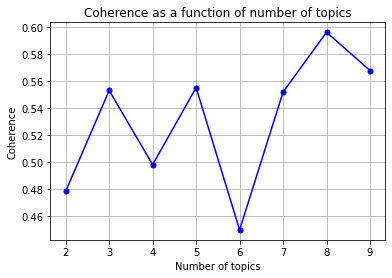

In [49]:
plot_coherence(id_dict, corpus, texts)

In [50]:
new_example = """Manchester United players slumped to the
turf
at full-time in Germany on Tuesday in acknowledgement of
what their
latest pedestrian first-half display had cost them. The
3-2 loss at
RB Leipzig means United will not be one of the 16 teams
in the draw
for the knockout stages of the Champions League. And this
is not the
only price for failure. The damage will be felt in the
accounts, in
the dealings they have with current and potentially
future players
and in the faith the fans have placed in manager Ole
Gunnar Solskjaer.
With Paul Pogba's agent angling for a move for his client
and ex-United
defender Phil Neville speaking of a "witchhunt" against
his former team-mate
Solskjaer, BBC Sport looks at the ramifications and
reaction to a big loss for United."""

In [51]:
def test_new_example(model, id_dict, input_string):
    input_list = clean_text(input_string)
    bow = id_dict.doc2bow(input_list)
    topics = model[bow]
    print(topics)

In [52]:
test_new_example(nmf_model, id_dict, new_example)

[(2, 0.09938121851363588), (4, 0.9006187814863641)]


## K-means topic modeling with BERT

In [54]:
# ! pip install -U sentence-transformers

In [72]:
import re
import string
import pandas as pd
from sklearn.cluster import KMeans
from nltk.probability import FreqDist
import nltk
import csv
from nltk.stem import SnowballStemmer
from sentence_transformers import SentenceTransformer

In [63]:
def tokenize_nltk(text):
    return nltk.tokenize.word_tokenize(text)

In [64]:
def read_in_csv(csv_file):
    with open(csv_file, 'r', encoding='utf-8') as fp:
        reader = csv.reader(fp, delimiter=',', 
                            quotechar='"')
        data_read = [row for row in reader]
        return data_read

In [65]:
def get_data(filename):
    data = read_in_csv(filename)
    data_dict = {}
    for row in data[1:]:
        category = row[0]
        text = row[1]
        if category not in data_dict.keys():
            data_dict[category] = []
        data_dict[category].append(text)
    return data_dict

In [66]:
from sklearn.model_selection import train_test_split
def divide_data(data_dict):
    train_dict = {}
    test_dict = {}
    for topic in data_dict.keys():
        text_list = data_dict[topic]
        x_train, x_test = train_test_split(text_list, test_size=0.2)
        train_dict[topic] = x_train
        test_dict[topic] = x_test
    return train_dict, test_dict

In [ ]:
bbc_dataset = '../Chapter04/bbc-text.csv'
stopwords_file_path = "stopwords.csv"

In [67]:
from nltk.stem import SnowballStemmer
# stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

def read_in_csv(csv_file):
    with open(csv_file, 'r', encoding='utf-8') as fp:
        reader = csv.reader(fp, delimiter=',', quotechar='"')
        data_read = [row for row in reader]
    return data_read

def get_stopwords(path):
    stopwords = read_in_csv(path)
    stopwords = [word[0] for word in stopwords]
    stemmed_stopwords = [stemmer.stem(word) for word in stopwords]
    stopwords = stopwords + stemmed_stopwords
    return stopwords

stopwords = get_stopwords(stopwords_file_path)

In [79]:
def get_most_frequent_words(text):
    word_list = tokenize_nltk(text)
    word_list = [word for word in word_list if word not in stopwords and word not in string.punctuation and re.search('[a-zA-Z]', word)]
    freq_dist = FreqDist(word_list)
    top_200 = freq_dist.most_common(200)
    top_200 = [word[0] for word in top_200]
    return top_200

In [80]:
def print_most_common_words_by_cluster(all_training, km, num_clusters):
    clusters = km.labels_.tolist()
    docs = {'text': all_training, 'cluster': clusters}
    frame = pd.DataFrame(docs, index = [clusters])
    for cluster in range(0, num_clusters):
        this_cluster_text = frame[frame['cluster'] == cluster]
        all_text = " ".join(this_cluster_text['text'].astype(str))
        top_200 = get_most_frequent_words(all_text)
        print(cluster)
        print(top_200)
    return frame

In [81]:
def preprocess(df):
    df = clean_data(df)
    df['text'] = df['text'].apply(lambda x: simple_preprocess(x, deacc=True))
    df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stopwords])
    return df

In [82]:
def test_new_example(km, model, example):
    embedded = model.encode([example])
    topic = km.predict(embedded)[0]
    print(topic)
    return topic

In [83]:
df = pd.read_csv(bbc_dataset)
df = preprocess(df)
df['text'] = df['text'].apply(lambda x: ' '.join(x))
documents = df['text'].values

In [84]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
encoded_data = model.encode(documents)

In [85]:
km = KMeans(n_clusters=5, random_state=0)
km.fit(encoded_data)

KMeans(n_clusters=5, random_state=0)

In [86]:
print_most_common_words_by_cluster(documents, km, 5)

0
['year', 'bn', 'growth', 'economy', 'sales', 'market', 'economic', 'prices', 'new', 'government', 'last', 'rise', 'bank', 'world', 'figures', 'years', 'rate', 'dollar', 'uk', 'expected', 'quarter', 'rates', 'profits', 'spending', 'oil', 'people', 'december', 'increase', 'months', 'analysts', 'month', 'strong', 'rose', 'time', 'first', 'interest', 'million', 'jobs', 'high', 'china', 'demand', 'company', 'three', 'business', 'tax', 'budget', 'january', 'price', 'next', 'report', 'fall', 'chief', 'firm', 'trade', 'hit', 'shares', 'costs', 'higher', 'low', 'country', 'fell', 'added', 'consumer', 'record', 'cut', 'recent', 'biggest', 'europe', 'deficit', 'set', 'cost', 'countries', 'profit', 'exports', 'annual', 'markets', 'euro', 'debt', 'india', 'financial', 'november', 'south', 'inflation', 'euros', 'back', 'domestic', 'week', 'group', 'european', 'president', 'stock', 'industry', 'earlier', 'says', 'data', 'five', 'house', 'economist', 'end', 'news', 'number', 'minister', 'share', 'gl

,text,cluster
4,tv future hands viewers home theatre systems p...,4
2,worldcom boss left books alone former worldcom...,2
1,tigers wary farrell gamble leicester say rushe...,1
1,yeading face newcastle fa cup premiership side...,1
3,ocean twelve raids box office ocean twelve cri...,3
...,...,...
0,cars pull retail figures retail sales fell jan...,0
2,kilroy unveils immigration policy ex chatshow ...,2
3,rem announce new glasgow concert band rem anno...,3
2,political squabbles snowball become commonplac...,2


In [87]:
new_example = """Manchester United players slumped to the
turf
at full-time in Germany on Tuesday in acknowledgement of
what their
latest pedestrian first-half display had cost them. The
3-2 loss at
RB Leipzig means United will not be one of the 16 teams
in the draw
for the knockout stages of the Champions League. And this
is not the
only price for failure. The damage will be felt in the
accounts, in
the dealings they have with current and potentially
future players
and in the faith the fans have placed in manager Ole
Gunnar Solskjaer.
With Paul Pogba's agent angling for a move for his client
and ex-United
defender Phil Neville speaking of a "witchhunt" against
his former team-mate
Solskjaer, BBC Sport looks at the ramifications and
reaction to a big loss for United."""

In [88]:
test_new_example(km, model, new_example)

1


1

## Topic modeling of short texts

In [10]:
import nltk
import numpy as np
import string
import pandas as pd
from gsdmm import MovieGroupProcess


In [11]:
def get_yelp_reviews(filename):
    reader = pd.read_json(filename, orient="records", lines=True, chunksize=10000)
    chunk = next(reader)
    text = ''
    for index, row in chunk.iterrows():
        row_text =row['text']
        lang = detect(row_text)
        if (lang == "en"):
            text = text + row_text.lower()
    return text

In [12]:
stopwords_file_path = "stopwords.csv"

In [13]:
from nltk.stem import SnowballStemmer
import csv
# stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

def read_in_csv(csv_file):
    with open(csv_file, 'r', encoding='utf-8') as fp:
        reader = csv.reader(fp, delimiter=',', quotechar='"')
        data_read = [row for row in reader]
    return data_read

def get_stopwords(path):
    stopwords = read_in_csv(path)
    stopwords = [word[0] for word in stopwords]
    stemmed_stopwords = [stemmer.stem(word) for word in stopwords]
    stopwords = stopwords + stemmed_stopwords
    return stopwords

stopwords = get_stopwords(stopwords_file_path)

In [14]:
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

In [15]:
def preprocess(text):
    sentences = tokenizer.tokenize(text)
    sentences = [nltk.tokenize.word_tokenize(sentence) for sentence in sentences]
    sentences = [list(set(word_list)) for word_list in sentences]
    sentences=[[word for word in word_list if word not in stopwords and word not in string.punctuation]
               for word_list in sentences]
    return sentences

In [16]:
def top_words(mgp, top_clusters, num_words):
    for cluster in top_clusters:
        sort_dicts = sorted(mgp.cluster_word_distribution[cluster].item(),
                            key= lambda k: k[1], reverse=True)[:num_words]
        print(f'Cluster {cluster}: {sort_dicts}')

In [18]:
yelp_reviews_file = "/Volumes/MAC-DISK/yelp_dataset/yelp_academic_dataset_review.json"

In [20]:
from langdetect import detect
reviews = get_yelp_reviews(yelp_reviews_file)
sentences = preprocess(reviews)

In [24]:
vocab = set(word for sentence in sentences for word in sentence)
n_terms = len(vocab)

In [25]:
mgp = MovieGroupProcess(K=25, alpha=0.1, beta=0.1, n_iters=30)
mgp.fit(sentences, n_terms)

In stage 0: transferred 60790 clusters with 25 clusters populated
In stage 1: transferred 49149 clusters with 25 clusters populated
In stage 2: transferred 39642 clusters with 25 clusters populated
In stage 3: transferred 32596 clusters with 25 clusters populated
In stage 4: transferred 28662 clusters with 25 clusters populated
In stage 5: transferred 26084 clusters with 25 clusters populated
In stage 6: transferred 24279 clusters with 23 clusters populated
In stage 7: transferred 23174 clusters with 21 clusters populated
In stage 8: transferred 22667 clusters with 21 clusters populated
In stage 9: transferred 21824 clusters with 21 clusters populated
In stage 10: transferred 21417 clusters with 21 clusters populated
In stage 11: transferred 21031 clusters with 20 clusters populated
In stage 12: transferred 20421 clusters with 18 clusters populated
In stage 13: transferred 20078 clusters with 18 clusters populated
In stage 14: transferred 20080 clusters with 18 clusters populated
In st

[16,
 23,
 23,
 16,
 18,
 22,
 3,
 3,
 3,
 3,
 3,
 13,
 16,
 10,
 18,
 13,
 16,
 22,
 17,
 17,
 23,
 16,
 23,
 15,
 17,
 22,
 22,
 7,
 7,
 7,
 17,
 23,
 16,
 7,
 18,
 23,
 16,
 16,
 11,
 17,
 16,
 22,
 18,
 3,
 3,
 16,
 15,
 22,
 22,
 17,
 23,
 15,
 23,
 11,
 18,
 3,
 3,
 3,
 23,
 23,
 7,
 18,
 11,
 16,
 23,
 7,
 15,
 15,
 7,
 16,
 7,
 15,
 13,
 13,
 3,
 18,
 13,
 22,
 3,
 3,
 16,
 16,
 15,
 16,
 16,
 13,
 22,
 17,
 18,
 3,
 22,
 22,
 7,
 23,
 23,
 18,
 13,
 7,
 7,
 11,
 7,
 7,
 7,
 7,
 17,
 7,
 7,
 7,
 16,
 23,
 22,
 15,
 3,
 13,
 17,
 17,
 13,
 23,
 13,
 13,
 7,
 13,
 13,
 15,
 7,
 22,
 15,
 13,
 3,
 16,
 10,
 22,
 10,
 18,
 23,
 23,
 17,
 22,
 18,
 17,
 22,
 18,
 3,
 22,
 3,
 23,
 13,
 7,
 15,
 7,
 17,
 3,
 18,
 3,
 16,
 13,
 15,
 15,
 7,
 15,
 15,
 7,
 11,
 15,
 11,
 13,
 15,
 11,
 15,
 22,
 13,
 15,
 11,
 16,
 3,
 22,
 13,
 3,
 13,
 13,
 16,
 13,
 15,
 22,
 16,
 13,
 22,
 15,
 7,
 17,
 15,
 7,
 15,
 11,
 13,
 23,
 13,
 11,
 18,
 7,
 11,
 11,
 7,
 13,
 16,
 11,
 16,
 11,
 13,
 13,


In [29]:
doc_count = np.array(mgp.cluster_doc_count)
top_clusters =  doc_count.argsort()[-15:][::-1]

In [31]:
def top_words_by_cluster(mgp, top_clusters, num_words):
    for cluster in top_clusters:
        sort_dicts = sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:num_words]
        print(f'Cluster {cluster}: {sort_dicts}')

In [32]:
top_words_by_cluster(mgp, top_clusters, 10)

Cluster 3: [('good', 1215), ('chicken', 1038), ('ordered', 873), ('sauce', 650), ('delicious', 643), ('cheese', 608), ('salad', 558), ('fried', 497), ('food', 471), ('great', 456)]
Cluster 22: [('place', 1976), ('food', 1575), ('good', 1181), ('great', 925), ('back', 924), ('service', 782), ('time', 723), ('definitely', 681), ('best', 581), ('try', 538)]
Cluster 13: [('food', 728), ('order', 722), ('get', 697), ('time', 633), ('minutes', 631), ('table', 487), ('wait', 480), ('came', 477), ('``', 453), ("''", 426)]
Cluster 16: [('place', 733), ('great', 523), ('nice', 451), ('food', 336), ('good', 336), ('clean', 313), ('bar', 311), ('room', 280), ('atmosphere', 270), ('restaurant', 260)]
Cluster 18: [('food', 1162), ('good', 845), ('great', 603), ('service', 484), ('menu', 421), ('selection', 363), ('prices', 317), ('price', 290), ('place', 287), ('beer', 278)]
Cluster 17: [('place', 642), ('time', 378), ('night', 360), ('get', 340), ('great', 305), ('good', 270), ('back', 255), ('park